<a href="https://colab.research.google.com/github/holezekki99/JODA2022/blob/harjoitusty%C3%B6/Goalie_salary_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Goalie salary predictor

In this workbook we're trying to make a model that could predict what would be the fair salary for NHL goalie based on his performance. We are looking if and how strong link there is between goalie stats and salary.

The statistical data for goelies performance is downloaded from Moneypuck.com website. The earnings are webscraped from spotrac.com.

### Aquiring data

We need goalie game statistics first. Separate files for every season. We'll be looking 3 year history:

In [18]:
# Create data-directory
!mkdir ./data

mkdir: cannot create directory ‘./data’: File exists


In [99]:
years = ['2020', '2021']

In [100]:
# Get the data for seasons starting 2019-2021 and write them to files
import pandas as pd
import requests

for i in years:
  year = str(i)
  url = ('https://moneypuck.com/moneypuck/playerData/seasonSummary/' + year + '/regular/goalies.csv')
  page = requests.get(url)
  r = requests.get(url)
  fname = ('./data/stat' + year + '.csv')
  open(fname, 'wb').write(r.content)


A data dictionary which explains all of the columns in the datasets can be downloaded [HERE](https://peter-tanner.com/moneypuck/downloads/MoneyPuckDataDictionaryForPlayers.csv)

Next step is to webscrape salary (caphit) information for seasons 2020-21 and 2021-22 and write the result into salaries.csv file.

We use beautifulsoup library for scraping:

In [142]:
from bs4 import BeautifulSoup

# Defining of the dataframe, we collect only name, year and caphit
df = pd.DataFrame(columns=['name', 'season', 'caphit'])

for i in years:
  year = str(i)
  url = ('https://www.spotrac.com/nhl/positional/' + year + '/goaltender/active-cap/')
  page = requests.get(url)
  soup = BeautifulSoup(page.content, 'html.parser')
  table = soup.find_all('table')[1]
  #table = soup.find_all('table')[1] # Table 1 is the list of goalies
  # Collecting Ddata
  for row in table.tbody.find_all('tr'):    
    # Find all data for each column
    columns = row.find_all('td')
    if(columns != []):
      name = columns[2].text.strip()
      # Use only familyname since the first names might be spelled differently.
      #name = name.split()[-1]
      
      # We later found out that there are two names wrongly spelled in salary dataset. Let's correct those:
      # Correct Vasilevskiy familyname
      if name == 'Andrei Vasilevski':
        name = 'Andrei Vasilevskiy'
      # Correct Grubauer's firstname
      if name == 'Phillip Grubauer':
        name = 'Philipp Grubauer'
      # Correct Talbot's firstname
      if name == 'Cameron Talbot':
        name = 'Cam Talbot'
      year = year
      caphit = columns[3].text.strip()
      df = df.append({'name': name,  'season': year, 'caphit': caphit}, ignore_index=True)


In [143]:
df

,name,season,caphit
0,Carey Price,2020,"$10,500,000"
1,Sergei Bobrovsky,2020,"$10,000,000"
2,Andrei Vasilevskiy,2020,"$9,500,000"
3,Tuukka Rask,2020,"$7,000,000"
4,Marc-Andre Fleury,2020,"$7,000,000"
...,...,...,...
156,Ville Husso,2021,"$750,000"
157,Connor Ingram,2021,"$733,333"
158,Dustin Tokarski,2021,"$725,000"
159,Kaapo Kahkonen,2021,"$725,000"


In [144]:
# Write the salaries to a salary.csv
df.to_csv('./data/salaries.csv', index=False)  

### Data cleaning and preprosessing
Next step is to merge the stats-datafiles into a single dataframe, investigate what we have on statistics and clean the data if needed:

We start by merging all stat-files into stat_df dataframe:

In [145]:
# Make one dataframe out of multiple statistical files (https://www.geeksforgeeks.org/how-to-merge-multiple-csv-files-into-a-single-pandas-dataframe/)

# importing libraries
import glob
import os
  
# merging the files
stat_files = os.path.join("./data", "stat*.csv")
  
# A list of all joined files is returned
stats_list = glob.glob(stat_files)
  
# Finally, the files are joined
stat_df = pd.concat(map(pd.read_csv, stats_list), ignore_index=True)

# Use only family name. Datasources seem to have differencies in firstnames. (https://pandas.pydata.org/docs/getting_started/intro_tutorials/10_text_data.html)
#stat_df['name'] = stat_df['name'].str.split().str.get(1)
stat_df.head()

,playerId,season,name,team,position,situation,games_played,icetime,xGoals,goals,...,highDangerShots,lowDangerxGoals,mediumDangerxGoals,highDangerxGoals,lowDangerGoals,mediumDangerGoals,highDangerGoals,blocked_shot_attempts,penalityMinutes,penalties
0,8475156,2021,Mikko Koskinen,EDM,G,other,45,3743.0,8.19,7.0,...,7.0,2.16,3.48,2.56,4.0,3.0,0.0,28.0,0.0,0.0
1,8475156,2021,Mikko Koskinen,EDM,G,all,45,157718.0,129.16,136.0,...,105.0,45.27,48.39,35.50,49.0,53.0,34.0,528.0,4.0,2.0
2,8475156,2021,Mikko Koskinen,EDM,G,5on5,45,129918.0,93.30,99.0,...,72.0,37.32,35.85,20.13,40.0,43.0,16.0,434.0,2.0,1.0
3,8475156,2021,Mikko Koskinen,EDM,G,4on5,45,11732.0,22.73,27.0,...,20.0,5.07,6.57,11.10,5.0,6.0,16.0,64.0,2.0,1.0
4,8475156,2021,Mikko Koskinen,EDM,G,5on4,45,12325.0,3.75,2.0,...,5.0,0.61,1.77,1.37,0.0,0.0,2.0,2.0,0.0,0.0


In [146]:
stat_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1085 entries, 0 to 1084
Data columns (total 36 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   playerId                   1085 non-null   int64  
 1   season                     1085 non-null   int64  
 2   name                       1085 non-null   object 
 3   team                       1085 non-null   object 
 4   position                   1085 non-null   object 
 5   situation                  1085 non-null   object 
 6   games_played               1085 non-null   int64  
 7   icetime                    1085 non-null   float64
 8   xGoals                     1085 non-null   float64
 9   goals                      1085 non-null   float64
 10  unblocked_shot_attempts    1085 non-null   float64
 11  xRebounds                  1085 non-null   float64
 12  rebounds                   1085 non-null   float64
 13  xFreeze                    1085 non-null   float

We have multiple rows for each season per goalie. There is also a row for all different game situations (5vs.5, 5vs.4 etc). We're not interested to the difference in different situations, but keep only the "all" rows: 

In [147]:
# remove rows using the drop() function
stat_df.drop(stat_df.index[stat_df['situation'] != 'all'], inplace=True)
stat_df.head()

,playerId,season,name,team,position,situation,games_played,icetime,xGoals,goals,...,highDangerShots,lowDangerxGoals,mediumDangerxGoals,highDangerxGoals,lowDangerGoals,mediumDangerGoals,highDangerGoals,blocked_shot_attempts,penalityMinutes,penalties
1,8475156,2021,Mikko Koskinen,EDM,G,all,45,157718.0,129.16,136.0,...,105.0,45.27,48.39,35.50,49.0,53.0,34.0,528.0,4.0,2.0
6,8478499,2021,Adin Hill,SJS,G,all,25,82573.0,56.91,61.0,...,48.0,19.80,20.83,16.29,22.0,21.0,18.0,354.0,0.0,0.0
11,8478009,2021,Ilya Sorokin,NYI,G,all,52,184337.0,135.77,123.0,...,122.0,52.35,46.82,36.60,59.0,38.0,26.0,826.0,0.0,0.0
16,8476434,2021,John Gibson,ANA,G,all,56,194135.0,157.74,172.0,...,121.0,55.84,60.81,41.07,73.0,74.0,25.0,729.0,12.0,6.0
21,8476341,2021,Anton Forsberg,OTT,G,all,46,154287.0,129.46,121.0,...,117.0,42.33,52.33,34.79,40.0,50.0,31.0,638.0,2.0,1.0


In [148]:
stat_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 217 entries, 1 to 1081
Data columns (total 36 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   playerId                   217 non-null    int64  
 1   season                     217 non-null    int64  
 2   name                       217 non-null    object 
 3   team                       217 non-null    object 
 4   position                   217 non-null    object 
 5   situation                  217 non-null    object 
 6   games_played               217 non-null    int64  
 7   icetime                    217 non-null    float64
 8   xGoals                     217 non-null    float64
 9   goals                      217 non-null    float64
 10  unblocked_shot_attempts    217 non-null    float64
 11  xRebounds                  217 non-null    float64
 12  rebounds                   217 non-null    float64
 13  xFreeze                    217 non-null    float6

The datatypes in the statististics dataframe are ok. The dataset is good quality, no need for further cleaning. For the time being we'll keep all columns but *penalityMinutes* and *penalties*.

In [149]:
stat_df.drop(['penalityMinutes', 'penalties'], axis=1, inplace=True)

The next step is to load salary.csv into sal_df:

In [150]:
# Load salaries.csv into a dataframe

sal_df = pd.read_csv('./data/salaries.csv')
sal_df.head()

,name,season,caphit
0,Carey Price,2020,"$10,500,000"
1,Sergei Bobrovsky,2020,"$10,000,000"
2,Andrei Vasilevskiy,2020,"$9,500,000"
3,Tuukka Rask,2020,"$7,000,000"
4,Marc-Andre Fleury,2020,"$7,000,000"


In [151]:
sal_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161 entries, 0 to 160
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    161 non-null    object
 1   season  161 non-null    int64 
 2   caphit  161 non-null    object
dtypes: int64(1), object(2)
memory usage: 3.9+ KB


In [152]:
# Convert year into numeric value:
sal_df['season'] = sal_df['season'].astype(int)

# Convert caphit into numeric value.
sal_df['caphit'] = sal_df['caphit'].replace("[$,]", "", regex=True).astype(int)

In [153]:
sal_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161 entries, 0 to 160
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    161 non-null    object
 1   season  161 non-null    int64 
 2   caphit  161 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 3.9+ KB


Now we need to merge the dataframes. Insert into stat_df a new column with salary information ("caphit").

In [154]:
stat_df.shape


(217, 34)

In [155]:
sal_df.shape

(161, 3)

Use merge method with outer left join. We keep all the values in stats dataframe and include the caphit (salary) from salary dataframe.

In [156]:
merged_df = pd.merge(stat_df, sal_df, how="left", on=["season", "name"])
merged_df

,playerId,season,name,team,position,situation,games_played,icetime,xGoals,goals,...,mediumDangerShots,highDangerShots,lowDangerxGoals,mediumDangerxGoals,highDangerxGoals,lowDangerGoals,mediumDangerGoals,highDangerGoals,blocked_shot_attempts,caphit
0,8475156,2021,Mikko Koskinen,EDM,G,all,45,157718.0,129.16,136.0,...,405.0,105.0,45.27,48.39,35.50,49.0,53.0,34.0,528.0,4500000.0
1,8478499,2021,Adin Hill,SJS,G,all,25,82573.0,56.91,61.0,...,175.0,48.0,19.80,20.83,16.29,22.0,21.0,18.0,354.0,NaN
2,8478009,2021,Ilya Sorokin,NYI,G,all,52,184337.0,135.77,123.0,...,388.0,122.0,52.35,46.82,36.60,59.0,38.0,26.0,826.0,4000000.0
3,8476434,2021,John Gibson,ANA,G,all,56,194135.0,157.74,172.0,...,501.0,121.0,55.84,60.81,41.07,73.0,74.0,25.0,729.0,6400000.0
4,8476341,2021,Anton Forsberg,OTT,G,all,46,154287.0,129.46,121.0,...,434.0,117.0,42.33,52.33,34.79,40.0,50.0,31.0,638.0,900000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212,8478048,2020,Igor Shesterkin,NYR,G,all,35,113941.0,85.99,83.0,...,249.0,82.0,28.81,29.87,27.31,30.0,28.0,25.0,443.0,925000.0
213,8477992,2020,Jonas Johansson,COL,G,all,15,49010.0,30.25,39.0,...,108.0,22.0,10.65,13.08,6.52,16.0,14.0,9.0,148.0,700000.0
214,8481519,2020,Spencer Knight,FLA,G,all,4,12414.0,6.90,8.0,...,12.0,8.0,2.69,1.27,2.94,3.0,1.0,4.0,35.0,925000.0
215,8480162,2020,Matiss Kivlenieks,CBJ,G,all,2,7401.0,6.00,7.0,...,16.0,5.0,1.81,1.87,2.31,2.0,2.0,3.0,26.0,NaN


Examine the dataset and look for seasons played per goalie. The idea is to remove those goalies that have not played too many games per season.

In [157]:
# copy the dataframe for visualisation
df1 = stat_df
df1 = df1.sort_values(by=['name', 'season'], ignore_index=True)
df1

,playerId,season,name,team,position,situation,games_played,icetime,xGoals,goals,...,lowDangerShots,mediumDangerShots,highDangerShots,lowDangerxGoals,mediumDangerxGoals,highDangerxGoals,lowDangerGoals,mediumDangerGoals,highDangerGoals,blocked_shot_attempts
0,8477180,2020,Aaron Dell,N.J,G,all,7,19150.0,12.26,22.0,...,160.0,41.0,10.0,4.86,4.64,2.76,11.0,9.0,2.0,48.0
1,8477180,2021,Aaron Dell,BUF,G,all,12,33923.0,33.64,38.0,...,329.0,102.0,33.0,10.33,12.20,11.11,11.0,14.0,13.0,130.0
2,8478903,2021,Adam Huska,NYR,G,all,1,3582.0,3.14,7.0,...,37.0,11.0,2.0,0.78,1.35,1.01,1.0,5.0,1.0,19.0
3,8478499,2020,Adin Hill,ARI,G,all,19,60354.0,46.03,46.0,...,557.0,130.0,39.0,16.85,15.81,13.37,17.0,18.0,11.0,196.0
4,8478499,2021,Adin Hill,SJS,G,all,25,82573.0,56.91,61.0,...,680.0,175.0,48.0,19.80,20.83,16.29,22.0,21.0,18.0,354.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212,8478024,2021,Ville Husso,STL,G,all,40,140474.0,113.54,100.0,...,1276.0,354.0,97.0,41.03,42.50,30.01,41.0,34.0,25.0,491.0
213,8477970,2020,Vitek Vanecek,WSH,G,all,37,126929.0,87.72,95.0,...,1129.0,246.0,81.0,30.84,29.40,27.47,36.0,34.0,25.0,426.0
214,8477970,2021,Vitek Vanecek,WSH,G,all,42,139043.0,97.64,103.0,...,1168.0,298.0,88.0,31.45,36.53,29.66,34.0,36.0,33.0,546.0
215,8477457,2021,Zach Fucale,WSH,G,all,4,10295.0,7.39,5.0,...,72.0,22.0,8.0,2.34,2.64,2.42,3.0,0.0,2.0,40.0


Examine how many seasons (between 2020-2021) goalies have played.

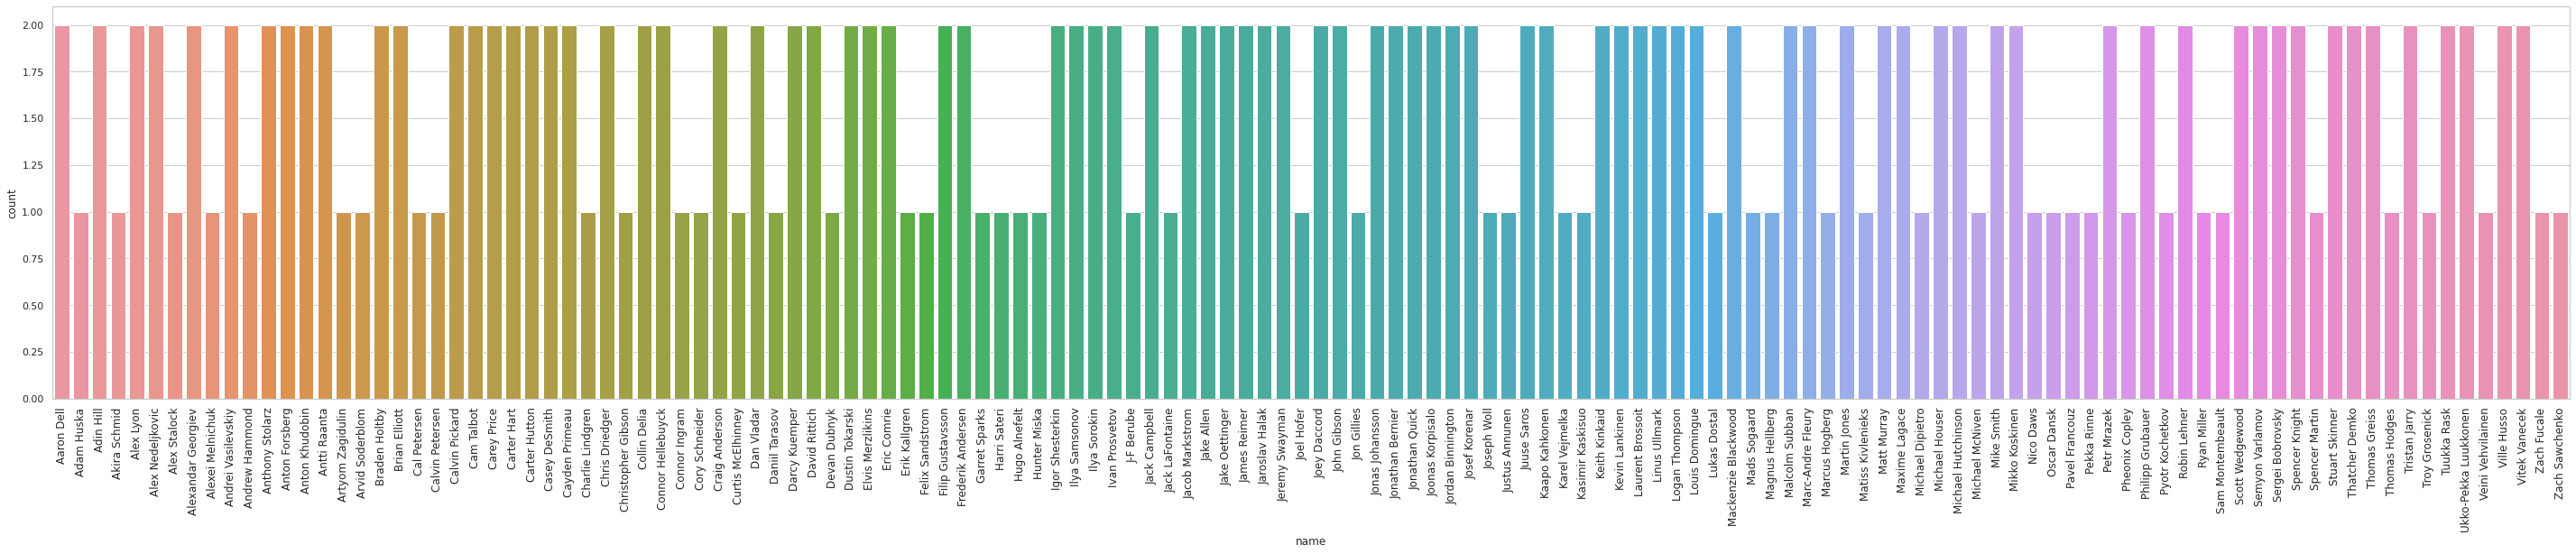

In [158]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()
sns.set_style("whitegrid")
sns.countplot(x = 'name', data = df1)
plt.rcParams["figure.figsize"] = (50,8)
plt.xticks(rotation=90, fontsize=12)
plt.show()

Find goalies that have played more than 5 games in one season:

In [162]:
df = merged_df
df = df[df.groupby('name')['games_played'].transform('max') > 5]
df.shape

(177, 35)

In [163]:
merged_df.shape

(217, 35)

Examine whether we have NaN values in caphit:

In [161]:
df[df['caphit'].isna()]

,playerId,season,name,team,position,situation,games_played,icetime,xGoals,goals,...,mediumDangerShots,highDangerShots,lowDangerxGoals,mediumDangerxGoals,highDangerxGoals,lowDangerGoals,mediumDangerGoals,highDangerGoals,blocked_shot_attempts,caphit
1,8478499,2021,Adin Hill,SJS,G,all,25,82573.0,56.91,61.0,...,175.0,48.0,19.80,20.83,16.29,22.0,21.0,18.0,354.0,NaN
9,8477180,2021,Aaron Dell,BUF,G,all,12,33923.0,33.64,38.0,...,102.0,33.0,10.33,12.20,11.11,11.0,14.0,13.0,130.0,NaN
13,8480925,2021,Pavel Francouz,COL,G,all,21,72009.0,52.94,51.0,...,168.0,53.0,15.88,20.61,16.45,17.0,17.0,17.0,257.0,NaN
17,8482076,2021,Nico Daws,NJD,G,all,25,76292.0,58.36,66.0,...,178.0,45.0,19.87,21.38,17.11,29.0,16.0,21.0,236.0,NaN
23,8471695,2021,Tuukka Rask,BOS,G,all,4,11781.0,9.56,14.0,...,26.0,12.0,1.80,3.40,4.36,3.0,5.0,6.0,40.0,NaN
25,8474636,2021,Michael Hutchinson,TOR,G,all,2,4723.0,4.09,6.0,...,15.0,5.0,0.84,1.89,1.36,3.0,2.0,1.0,13.0,NaN
30,8476234,2021,Keith Kinkaid,NYR,G,all,1,3600.0,2.24,2.0,...,8.0,1.0,0.94,1.09,0.21,1.0,1.0,0.0,9.0,NaN
31,8481033,2021,Akira Schmid,NJD,G,all,6,14159.0,9.72,19.0,...,31.0,8.0,3.53,4.01,2.18,6.0,13.0,0.0,54.0,NaN
35,8476316,2021,Laurent Brossoit,VGK,G,all,24,76886.0,60.68,62.0,...,203.0,55.0,17.14,25.56,17.98,22.0,25.0,15.0,338.0,NaN
38,8478435,2021,Dan Vladar,CGY,G,all,23,74588.0,53.19,57.0,...,195.0,37.0,19.41,23.21,10.57,19.0,27.0,11.0,273.0,NaN


We see that not all goalies have salary information for every season.

We can replace goalies NaN caphit values by inserting their average caphit value to those years caphit is missing.

In [164]:
# fill caphit nan values (had not played for that season) with players average caphit (https://stackoverflow.com/questions/19966018/pandas-filling-missing-values-by-mean-in-each-group)
df['caphit'] = df['caphit'].fillna(df.groupby('name')['caphit'].transform('mean')) 
df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,playerId,season,name,team,position,situation,games_played,icetime,xGoals,goals,...,mediumDangerShots,highDangerShots,lowDangerxGoals,mediumDangerxGoals,highDangerxGoals,lowDangerGoals,mediumDangerGoals,highDangerGoals,blocked_shot_attempts,caphit
0,8475156,2021,Mikko Koskinen,EDM,G,all,45,157718.0,129.16,136.0,...,405.0,105.0,45.27,48.39,35.50,49.0,53.0,34.0,528.0,4500000.0
1,8478499,2021,Adin Hill,SJS,G,all,25,82573.0,56.91,61.0,...,175.0,48.0,19.80,20.83,16.29,22.0,21.0,18.0,354.0,800000.0
2,8478009,2021,Ilya Sorokin,NYI,G,all,52,184337.0,135.77,123.0,...,388.0,122.0,52.35,46.82,36.60,59.0,38.0,26.0,826.0,4000000.0
3,8476434,2021,John Gibson,ANA,G,all,56,194135.0,157.74,172.0,...,501.0,121.0,55.84,60.81,41.07,73.0,74.0,25.0,729.0,6400000.0
4,8476341,2021,Anton Forsberg,OTT,G,all,46,154287.0,129.46,121.0,...,434.0,117.0,42.33,52.33,34.79,40.0,50.0,31.0,638.0,900000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,8471695,2020,Tuukka Rask,BOS,G,all,24,83787.0,56.64,53.0,...,191.0,49.0,17.30,23.59,15.74,19.0,20.0,14.0,257.0,7000000.0
212,8478048,2020,Igor Shesterkin,NYR,G,all,35,113941.0,85.99,83.0,...,249.0,82.0,28.81,29.87,27.31,30.0,28.0,25.0,443.0,925000.0
213,8477992,2020,Jonas Johansson,COL,G,all,15,49010.0,30.25,39.0,...,108.0,22.0,10.65,13.08,6.52,16.0,14.0,9.0,148.0,700000.0
214,8481519,2020,Spencer Knight,FLA,G,all,4,12414.0,6.90,8.0,...,12.0,8.0,2.69,1.27,2.94,3.0,1.0,4.0,35.0,925000.0


In [165]:
df[df['caphit'].isna()]

,playerId,season,name,team,position,situation,games_played,icetime,xGoals,goals,...,mediumDangerShots,highDangerShots,lowDangerxGoals,mediumDangerxGoals,highDangerxGoals,lowDangerGoals,mediumDangerGoals,highDangerGoals,blocked_shot_attempts,caphit
13,8480925,2021,Pavel Francouz,COL,G,all,21,72009.0,52.94,51.0,...,168.0,53.0,15.88,20.61,16.45,17.0,17.0,17.0,257.0,NaN
17,8482076,2021,Nico Daws,NJD,G,all,25,76292.0,58.36,66.0,...,178.0,45.0,19.87,21.38,17.11,29.0,16.0,21.0,236.0,NaN
25,8474636,2021,Michael Hutchinson,TOR,G,all,2,4723.0,4.09,6.0,...,15.0,5.0,0.84,1.89,1.36,3.0,2.0,1.0,13.0,NaN
31,8481033,2021,Akira Schmid,NJD,G,all,6,14159.0,9.72,19.0,...,31.0,8.0,3.53,4.01,2.18,6.0,13.0,0.0,54.0,NaN
38,8478435,2021,Dan Vladar,CGY,G,all,23,74588.0,53.19,57.0,...,195.0,37.0,19.41,23.21,10.57,19.0,27.0,11.0,273.0,NaN
45,8478470,2021,Sam Montembeault,MTL,G,all,38,116569.0,104.71,122.0,...,350.0,101.0,32.08,42.37,30.25,39.0,56.0,27.0,434.0,NaN
82,8479313,2021,Zach Sawchenko,SJS,G,all,7,16138.0,16.02,15.0,...,53.0,14.0,4.41,6.35,5.27,3.0,7.0,5.0,72.0,NaN
90,8476899,2021,Matt Murray,OTT,G,all,20,70891.0,63.16,60.0,...,226.0,59.0,17.89,26.74,18.53,13.0,30.0,17.0,293.0,NaN
95,8478902,2021,Erik Kallgren,TOR,G,all,14,46769.0,37.80,43.0,...,111.0,39.0,11.79,13.74,12.26,15.0,14.0,14.0,154.0,NaN
96,8478916,2021,Joey Daccord,SEA,G,all,5,17593.0,15.15,21.0,...,50.0,18.0,3.66,5.94,5.54,7.0,8.0,6.0,54.0,NaN


Caphit column has 23 NaN values. Let's examine what they are:

In [166]:
nan_values = df[df['caphit'].isna()]
nan_values['name'].unique

<bound method Series.unique of 13          Pavel Francouz
17               Nico Daws
25      Michael Hutchinson
31            Akira Schmid
38              Dan Vladar
45        Sam Montembeault
82          Zach Sawchenko
90             Matt Murray
95           Erik Kallgren
96            Joey Daccord
107             J-F Berube
111         Stuart Skinner
113    Mackenzie Blackwood
115     Alexandar Georgiev
124           Devan Dubnyk
131         Stuart Skinner
135     Alexandar Georgiev
136            Matt Murray
140        Calvin Petersen
151    Mackenzie Blackwood
171           Joey Daccord
186             Dan Vladar
192     Michael Hutchinson
Name: name, dtype: object>

Drop remaining rows with caphit as NaN:

In [167]:
df = df[df['caphit'].notna()]

In [168]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 154 entries, 0 to 216
Data columns (total 35 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   playerId                   154 non-null    int64  
 1   season                     154 non-null    int64  
 2   name                       154 non-null    object 
 3   team                       154 non-null    object 
 4   position                   154 non-null    object 
 5   situation                  154 non-null    object 
 6   games_played               154 non-null    int64  
 7   icetime                    154 non-null    float64
 8   xGoals                     154 non-null    float64
 9   goals                      154 non-null    float64
 10  unblocked_shot_attempts    154 non-null    float64
 11  xRebounds                  154 non-null    float64
 12  rebounds                   154 non-null    float64
 13  xFreeze                    154 non-null    float64

Finally the dataframe looks ok.

### Data describing

In [169]:
df.tail()

,playerId,season,name,team,position,situation,games_played,icetime,xGoals,goals,...,mediumDangerShots,highDangerShots,lowDangerxGoals,mediumDangerxGoals,highDangerxGoals,lowDangerGoals,mediumDangerGoals,highDangerGoals,blocked_shot_attempts,caphit
211,8471695,2020,Tuukka Rask,BOS,G,all,24,83787.0,56.64,53.0,...,191.0,49.0,17.30,23.59,15.74,19.0,20.0,14.0,257.0,7000000.0
212,8478048,2020,Igor Shesterkin,NYR,G,all,35,113941.0,85.99,83.0,...,249.0,82.0,28.81,29.87,27.31,30.0,28.0,25.0,443.0,925000.0
213,8477992,2020,Jonas Johansson,COL,G,all,15,49010.0,30.25,39.0,...,108.0,22.0,10.65,13.08,6.52,16.0,14.0,9.0,148.0,700000.0
214,8481519,2020,Spencer Knight,FLA,G,all,4,12414.0,6.90,8.0,...,12.0,8.0,2.69,1.27,2.94,3.0,1.0,4.0,35.0,925000.0
216,8475717,2020,Calvin Pickard,DET,G,all,6,18203.0,11.04,16.0,...,35.0,6.0,4.58,4.34,2.11,5.0,9.0,2.0,60.0,800000.0


Start visually describe the salarydata. In order to understand the current situation in salaries, let's look only season 21-22.



In [176]:
df21 = df[df.season == 2021]
df21 = df21.sort_values(by=['name', 'season'], ignore_index=True)
df21.shape

(78, 35)

We're now looking the season 21-22 salary information of 73 goalies that have played in season at least 25 games since the start of season 2019-2022.

First we use boxplot from seaborn library to find:
- min and max caphits
- the blue box represents interquartile range (IQR) (25th to the 75th percentile)
- outliers, if any

In [177]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()
sns.set_style("whitegrid")

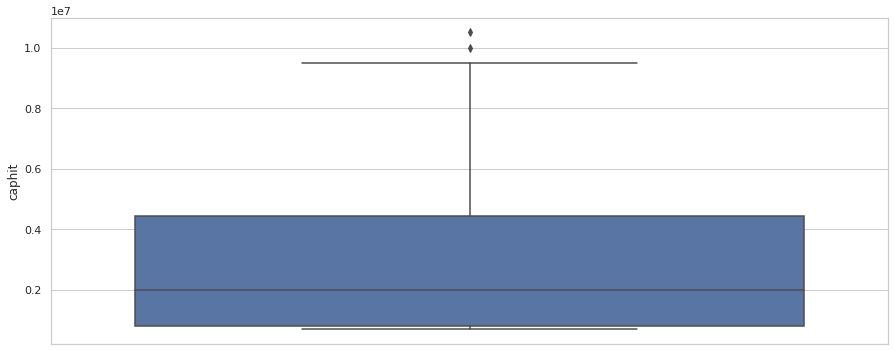

In [178]:
sns.boxplot(data = df21, y = 'caphit')

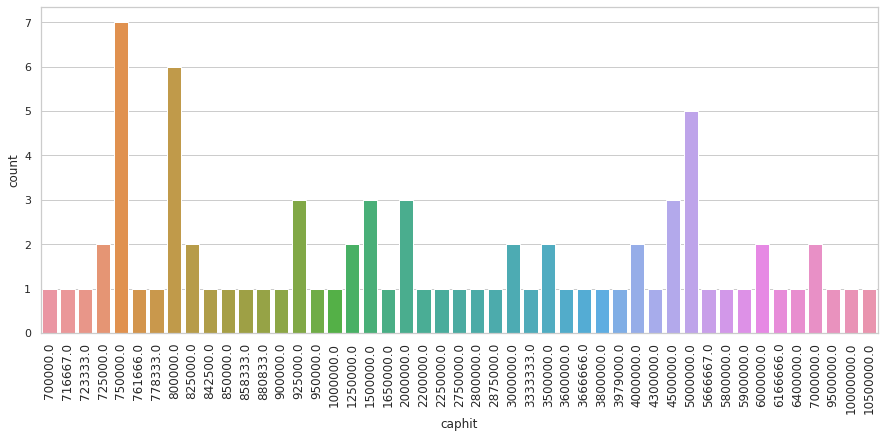

In [180]:
# For this visualisation, sort data by salary:
df21 = df21.sort_values(by=['caphit'], ignore_index=True)
sns.countplot(x = 'caphit', data = df21)
plt.rcParams["figure.figsize"] = (15,6)
plt.xticks(rotation=90, fontsize=12)
plt.show()

We see that most common salary is 750'000, which is the normal entry level contract.

-----

### Machine Learning

In this section we begin the process of finding what features in the statistic correlate with the salary.